Train images path detected.
Descriptors vstacked.


/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Descriptors clustered.
Images features extracted.
Train images normalized.


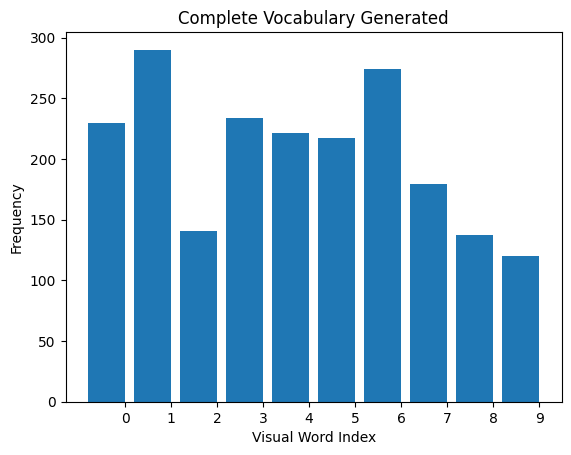

Features histogram plotted.
0.5 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[251 149]
 [  0   0]]
Normalized confusion matrix
[[0.63 0.37]
 [ nan  nan]]


/var/folders/8f/jyxqg8fx7mx9rzbl0pts9xd40000gn/T/ipykernel_8896/1615492709.py:113: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


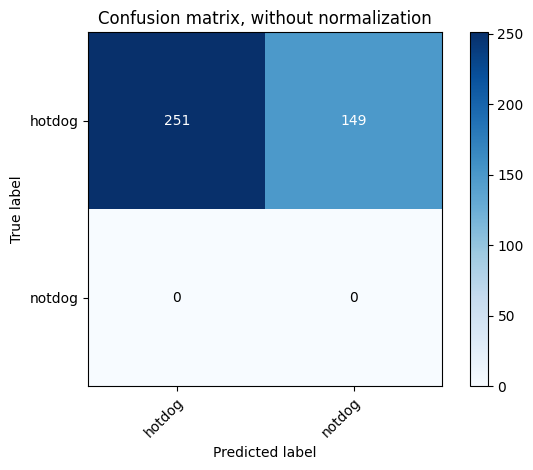

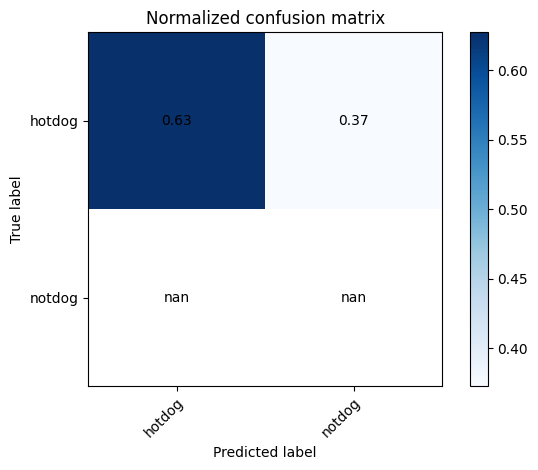

Confusion matrixes plotted.
accuracy score: 0.627
Accuracy calculated.
Execution done.


In [2]:
import argparse
from tqdm import tqdm
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        if folder != '.DS_Store':
            for file in  os.listdir(os.path.join(path, folder)):
                images.append(os.path.join(path, os.path.join(folder, file)))

    if(train is True):
        np.random.shuffle(images)
    
    return images

def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (4242 / (2 * 2121)),
        1: (4242 / (2 * 2121)) 
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    #class_names = ["city", "face", "green", "house_building", "house_indoor", "office", "sea"]
    class_names = ['hotdog','notdog']
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

def trainModel(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    #label_count = 7
    label_count = 2
    image_count = len(images)

    for img_path in images:
        # if("city" in img_path):
        #     class_index = 0
        # elif("face" in img_path):
        #     class_index = 1
        # elif("green" in img_path):
        #     class_index = 2
        # elif("house_building" in img_path):
        #     class_index = 3
        # elif("house_indoor" in img_path):
        #     class_index = 4
        # elif("office" in img_path):
        #   class_index = 5
        # else:
        #   class_index = 6
        if ('hotdog' in img_path):
            class_index = 0
        else: class_index = 1

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    # name_dict =	{
    #     "0": "city",
    #     "1": "face",
    #     "2": "green",
    #     "3": "house_building",
    #     "4": "house_indoor",
    #     "5": "office",
    #     "6": "sea"
    # }
    name_dict = {
        '0': 'hotdog',
        '1': 'notdog'
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            # if("city" in img_path):
            #     true.append("city")
            # elif("face" in img_path):
            #     true.append("face")
            # elif("green" in img_path):
            #     true.append("green")
            # elif("house_building" in img_path):
            #     true.append("house_building")
            # elif("house_indoor" in img_path):
            #     true.append("house_indoor")
            # elif("office" in img_path):
            #     true.append("office")
            # else:
            #     true.append("sea")
            if ('hotdog' in img_path): true.append('hotdog')
            else: true.append('hotdog')

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")

def execute(train_path, test_path, no_clusters, kernel):
    kmeans, scale, svm, im_features = trainModel(train_path, no_clusters, kernel)
    testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)

if __name__ == '__main__':

    # parser = argparse.ArgumentParser()

    # parser.add_argument('--train_path', action="store", dest="train_path", required=True)
    # parser.add_argument('--test_path', action="store", dest="test_path", required=True)
    # parser.add_argument('--no_clusters', action="store", dest="no_clusters", default=50)
    # parser.add_argument('--kernel_type', action="store", dest="kernel_type", default="linear")

    # args =  vars(parser.parse_args())
    # if(not(args['kernel_type'] == "linear" or args['kernel_type'] == "precomputed")):
    #     print("Kernel type must be either linear or precomputed")
    #     exit(0)

    # execute(args['train_path'], args['test_path'], int(args['no_clusters']), args['kernel_type'])
    train_path = './train/'
    #print(os.listdir(train_path))
    test_path = './test/'
    execute(train_path,test_path,10,'linear')
